In [1]:
# Import basic libraries
import numpy as np 
import pandas as pd
import joblib # for saving models

In [2]:
# For Google Colab only
# from google.colab import files

In [3]:
# Load local data
data = pd.read_csv('data/data.csv',index_col = 'ID')

In [4]:
# Load data from GitHub
# data_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data.csv?token=AIUUIXPDCVIHEXYNIDVP23K6UEHRA'
# data = pd.read_csv(data_url, index_col = 'ID')


## Variables
There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)


## Data Cleaning
- No missing values, but there are a few anomalous things
- Variable name:
    1. PAY_0 is very confusing, should be changed to PAY_1 in consistensy with other variable names
    2. Change target variable name from 'default.pay.next.month' to 'def_pay'
- Understand categorical and numerical data respectively


In [5]:
# Change variable name
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [6]:
# To have a general idea of the default probability
data['def_pay'].value_counts()[1] / data.shape[0]

0.2212

In [7]:
# Categorical variables
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [8]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [9]:
# Missing values are filled with random value according to probability of occurrence
mask_edu_good=data['EDUCATION'].isin(range(1,5))
data['EDUCATION'].mask(~mask_edu_good,data['EDUCATION'][mask_edu_good].sample(n=(~mask_edu_good).sum(),replace=True).tolist(),inplace=True)
data['EDUCATION'].value_counts()

2    14177
1    10732
3     4966
4      125
Name: EDUCATION, dtype: int64

In [10]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [11]:
mask_marriage_good=data['MARRIAGE'].isin(range(1,4))
data['MARRIAGE'].mask(~mask_marriage_good,data['MARRIAGE'][mask_marriage_good].sample(n=(~mask_marriage_good).sum(),replace=True).tolist(),inplace=True)
data['MARRIAGE'].value_counts()

2    15984
1    13693
3      323
Name: MARRIAGE, dtype: int64

In [12]:
# Create lists for relevant numerical features
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [13]:
# final check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [14]:
# export to csv
data.to_csv('data/data_clean.csv')

# Naive Bayes Model Building

## First method: Discretizing Continuous Feature for Naive Bayes

### 1. With data normalization and equal interval bins

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

#### Age

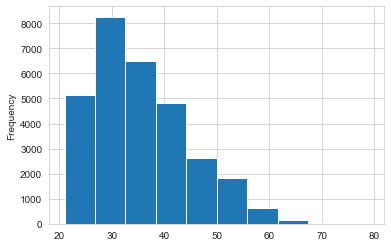

In [16]:
data['AGE'].plot(kind='hist')

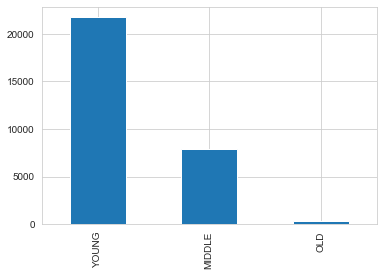

In [17]:
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE_BINNED']=pd.cut(data['AGE'],3,labels=group_age)
data['AGE_BINNED'].value_counts().plot(kind='bar')

In [18]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()

In [19]:
data['AGE_encoded'] = le.fit_transform(data['AGE_BINNED'])

#### Limit Balance

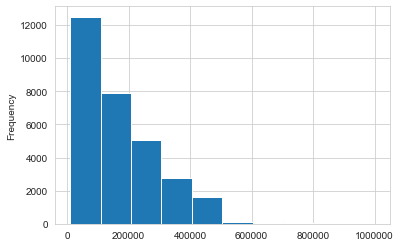

In [20]:
data['LIMIT_BAL'].plot(kind='hist')

In [21]:
# Normalize limit balance data
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
log.fit(data[['LIMIT_BAL']])
data['LIMIT_BAL_log'] =log.transform(data[['LIMIT_BAL']])

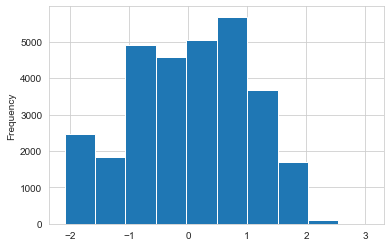

In [22]:
data['LIMIT_BAL_log'].plot(kind='hist')

In [23]:
pd.cut(data['LIMIT_BAL_log'], bins=5).value_counts()

(-0.033, 1.0]       10723
(-1.066, -0.033]     9501
(1.0, 2.033]         5345
(-2.104, -1.066]     4311
(2.033, 3.066]        120
Name: LIMIT_BAL_log, dtype: int64

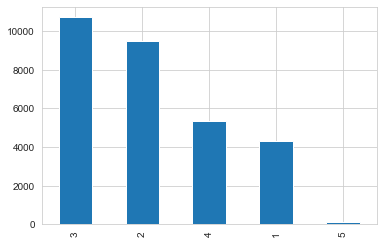

In [24]:
# binning of limit balance
data['LIMIT_BAL_BINNED']=pd.cut(data['LIMIT_BAL_log'],5,labels=range(1,6))
data['LIMIT_BAL_BINNED'].value_counts().plot(kind='bar')

#### Previous Panyments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a596150>,
      dtype=object)

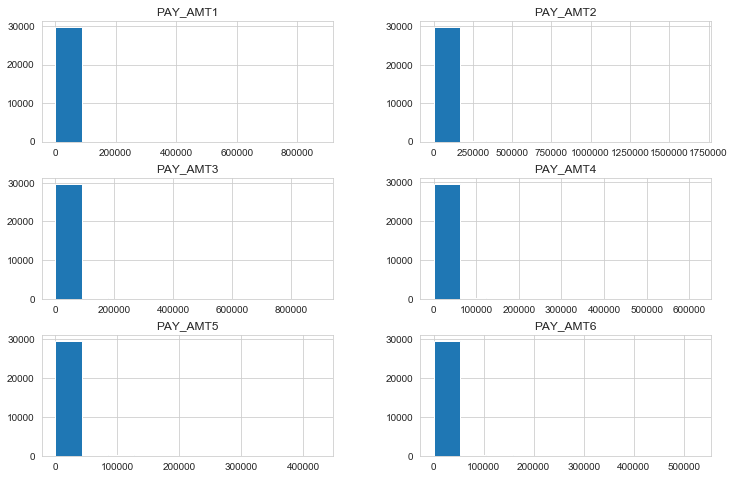

In [25]:
# histogram for preious payments
data.hist(column= payments, figsize=(12, 8))

In [26]:
# Normalize previous payments data
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
for x in payments:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ddd0450>,
      dtype=object)

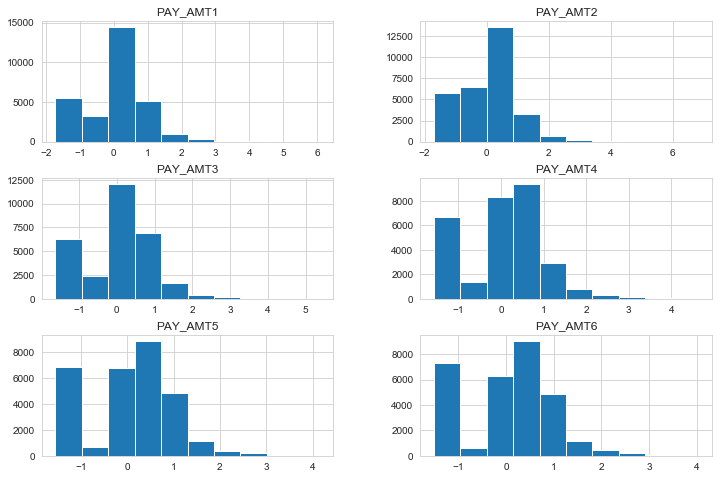

In [27]:
data.hist(column= payments, figsize=(12, 8))

In [28]:
pd.cut(data['PAY_AMT1'], bins=5).value_counts()

(-0.164, 1.396]     19686
(-1.732, -0.164]     8747
(1.396, 2.957]       1394
(2.957, 4.517]        167
(4.517, 6.077]          6
Name: PAY_AMT1, dtype: int64

In [29]:
# binning of previous payments
for x in payments:
    data[x+'_BINNED']=pd.cut(data[x],5,labels=range(1,6))

#### Bill Statements

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1de52fd0>,
      dtype=object)

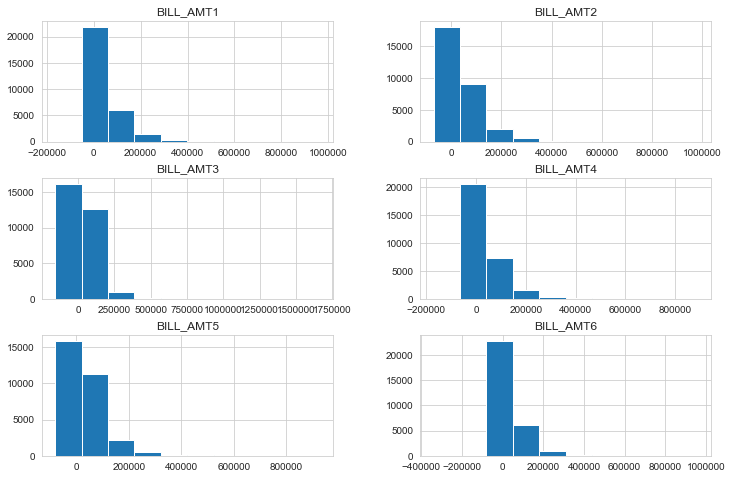

In [30]:
# histogram for bill statements
data.hist(column= bill_amounts, figsize=(12, 8))

In [31]:
pd.cut(data['BILL_AMT1'], bins=3).value_counts()

(-166710.091, 211117.0]    28671
(211117.0, 587814.0]        1317
(587814.0, 964511.0]          12
Name: BILL_AMT1, dtype: int64

In [32]:
# binning of bill statements
for x in bill_amounts:
    data[x+'_BINNED']=pd.cut(data[x],3,labels=range(1,4))

#### Repayments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e296190>,
      dtype=object)

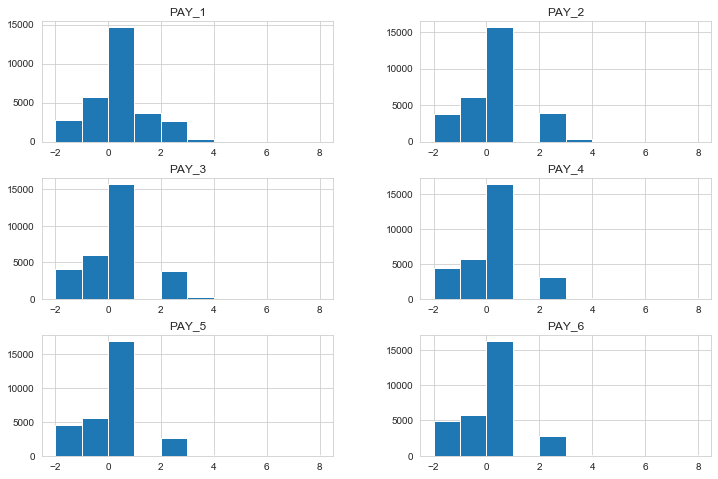

In [33]:
data.hist(column= repayments, figsize=(12, 8))

In [34]:
#MutilinomialNB disallow negative input, add a constant to all repayments status value
data[repayments]=data[repayments]+9

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e709cd0>,
      dtype=object)

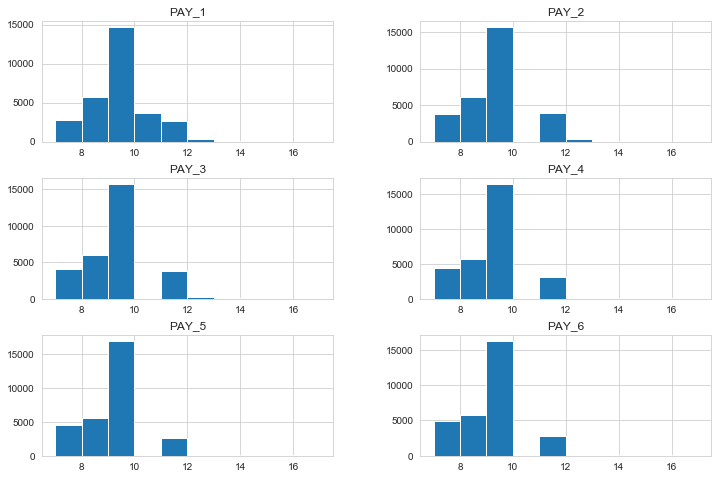

In [35]:
data.hist(column= repayments, figsize=(12, 8))

#### Model Building

In [36]:
bill_amounts_binned = ['BILL_AMT1_BINNED', 'BILL_AMT2_BINNED', 'BILL_AMT3_BINNED', 'BILL_AMT4_BINNED', 'BILL_AMT5_BINNED', 'BILL_AMT6_BINNED']
payments_binned = ['PAY_AMT1_BINNED', 'PAY_AMT2_BINNED', 'PAY_AMT3_BINNED', 'PAY_AMT4_BINNED', 'PAY_AMT5_BINNED', 'PAY_AMT6_BINNED']          
features=['LIMIT_BAL_BINNED','SEX','EDUCATION','MARRIAGE','AGE_encoded'] + repayments + bill_amounts_binned + payments_binned
X=data[features]
y=data['def_pay']

In [37]:
#Import Multinomial Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

#### Model Evaluation

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [39]:
# Accuracy from cross validation 
# import cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict
score = cross_val_score(mnb,X,y,cv=10)
score.mean()

0.7825666666666666

In [40]:
# get predicted class for y
y_pred_class = cross_val_predict(mnb,X,y,cv=10)

In [41]:
pred_proba = cross_val_predict(mnb, X,y,cv=10, method = 'predict_proba')
pred_proba

array([[0.57875543, 0.42124457],
       [0.71123967, 0.28876033],
       [0.8054925 , 0.1945075 ],
       ...,
       [0.63542922, 0.36457078],
       [0.83003826, 0.16996174],
       [0.76590087, 0.23409913]])

In [42]:
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))

Confusion Matrix: 
 [[23287    77]
 [ 6446   190]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       0.71      0.03      0.06      6636

    accuracy                           0.78     30000
   macro avg       0.75      0.51      0.47     30000
weighted avg       0.77      0.78      0.70     30000



In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y, pred_proba[:,1], pos_label=1)

In [44]:
# Area under ROC curve
roc_auc=auc(fpr,tpr)
roc_auc

0.7167328210022911

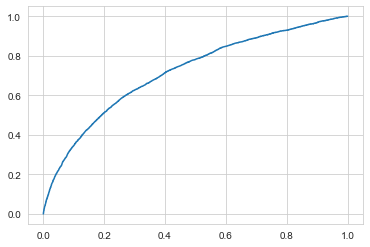

In [45]:
plt.plot(fpr,tpr)

### 2. With equal quantity bins

#### Age

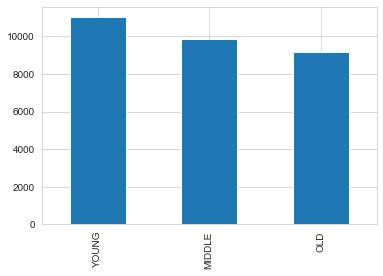

In [46]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE_BINNED']=pd.qcut(data['AGE'],3,labels=group_age)
data['AGE_BINNED'].value_counts().plot(kind='bar')

In [47]:
data['AGE_BINNED'].value_counts()

YOUNG     11013
MIDDLE     9843
OLD        9144
Name: AGE_BINNED, dtype: int64

In [48]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()

In [49]:
data['AGE_encoded'] = le.fit_transform(data['AGE_BINNED'])

In [50]:
data['AGE_BINNED']

ID
1         YOUNG
2         YOUNG
3        MIDDLE
4        MIDDLE
5           OLD
          ...  
29996    MIDDLE
29997       OLD
29998    MIDDLE
29999       OLD
30000       OLD
Name: AGE_BINNED, Length: 30000, dtype: category
Categories (3, object): [YOUNG < MIDDLE < OLD]

#### Limit Balance

In [51]:
pd.qcut(data['LIMIT_BAL'],5).value_counts()

(9999.999, 50000.0]      7676
(100000.0, 180000.0]     6123
(270000.0, 1000000.0]    5958
(180000.0, 270000.0]     5421
(50000.0, 100000.0]      4822
Name: LIMIT_BAL, dtype: int64

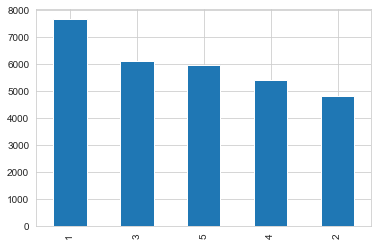

In [52]:
# binning of limit balance
data['LIMIT_BAL_BINNED']=pd.qcut(data['LIMIT_BAL'],5,labels=range(1,6))
data['LIMIT_BAL_BINNED'].value_counts().plot(kind='bar')

#### Previous Payments

In [53]:
# binning of previous payments
for x in payments:
    data[x+'_BINNED']=pd.qcut(data[x],4,labels=range(1,5))

#### Bill Statement

In [54]:
# binning of bill statements
for x in bill_amounts:
    data[x+'_BINNED']=pd.qcut(data[x],3,labels=range(1,4))

#### Repayments

In [55]:
data[repayments]=data[repayments]+9

#### Model Building

In [56]:
bill_amounts_binned = ['BILL_AMT1_BINNED', 'BILL_AMT2_BINNED', 'BILL_AMT3_BINNED', 'BILL_AMT4_BINNED', 'BILL_AMT5_BINNED', 'BILL_AMT6_BINNED']
payments_binned = ['PAY_AMT1_BINNED', 'PAY_AMT2_BINNED', 'PAY_AMT3_BINNED', 'PAY_AMT4_BINNED', 'PAY_AMT5_BINNED', 'PAY_AMT6_BINNED']          
features=['LIMIT_BAL_BINNED','SEX','EDUCATION','MARRIAGE','AGE_encoded'] + repayments + bill_amounts_binned + payments_binned
X=data[features]
y=data['def_pay']

In [57]:
#Import Multinomial Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

#### Model Evaluation

In [58]:
# Accuracy from cross validation 
# import cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict
score = cross_val_score(mnb,X,y,cv=10)
score.mean()

0.7847666666666665

In [59]:
# get predicted class for y
y_pred_class = cross_val_predict(mnb,X,y,cv=10)

In [60]:
pred_proba = cross_val_predict(mnb, X,y,cv=10, method = 'predict_proba')
pred_proba

array([[0.33710238, 0.66289762],
       [0.61895973, 0.38104027],
       [0.74503797, 0.25496203],
       ...,
       [0.60064472, 0.39935528],
       [0.86504946, 0.13495054],
       [0.62515853, 0.37484147]])

In [61]:
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))

Confusion Matrix: 
 [[22348  1016]
 [ 5441  1195]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     23364
           1       0.54      0.18      0.27      6636

    accuracy                           0.78     30000
   macro avg       0.67      0.57      0.57     30000
weighted avg       0.75      0.78      0.74     30000



In [62]:
fpr, tpr, thresholds = roc_curve(y, pred_proba[:,1], pos_label=1)

In [63]:
# Area under ROC curve
roc_auc=auc(fpr,tpr)
roc_auc

0.6880443020689213

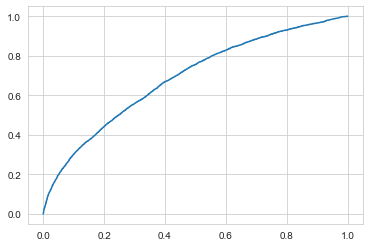

In [64]:
plt.plot(fpr,tpr)

## Second method: Use GaussianNB for Continuous Features and MultinomialNB for Categorical Features respectively

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

### Normalize skewed features

#### Limit Balance

In [66]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
log.fit(data[['LIMIT_BAL']])
data['LIMIT_BAL_log'] =log.transform(data[['LIMIT_BAL']])

#### Previous Payments

In [67]:
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
for x in payments:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

#### Bill Statement


In [68]:
#from sklearn.preprocessing import PowerTransformer
#log = PowerTransformer()
#for x in bill_amounts:
#    log.fit(data[[x]])
#    data[x] =log.transform(data[[x]])
#data.hist(column= bill_amounts, figsize=(12, 8))

#### Repayments

In [69]:
data[repayments]=data[repayments]+9

#### Model Building

In [70]:
# define independent attributes 
features1=['LIMIT_BAL','AGE'] + bill_amounts + payments

# assign values for independent variables and target variable ('Personal Loan')
X1 = data [features1]
y = data ['def_pay']

In [71]:
#Import Gaussian Naive Bayes model from sklearn
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Naive Bayes Classifier
gnb = GaussianNB() 

In [72]:
# import cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict
pred_proba = cross_val_predict(gnb, X1,y,cv=10, method = 'predict_proba')
pred_proba

array([[0.63830326, 0.36169674],
       [0.70282364, 0.29717636],
       [0.71676872, 0.28323128],
       ...,
       [0.67900981, 0.32099019],
       [0.73704957, 0.26295043],
       [0.6902985 , 0.3097015 ]])

In [73]:
# define independent attributes 
features2=['SEX','EDUCATION','MARRIAGE'] + repayments

# assign values for independent variables and target variable ('Personal Loan')
X2 = data [features2]
y = data ['def_pay']

In [74]:
#Import Multinomial Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

In [75]:
score = cross_val_score(mnb,X2,y,cv=10)
score.mean()

0.7787999999999999

In [76]:
pred_proba2 = cross_val_predict(mnb, X2,y,cv=10, method = 'predict_proba')
pred_proba2

array([[0.7603064 , 0.2396936 ],
       [0.79679745, 0.20320255],
       [0.79471173, 0.20528827],
       ...,
       [0.7467207 , 0.2532793 ],
       [0.76293165, 0.23706835],
       [0.76267328, 0.23732672]])

In [77]:
predictions=[]
for x in range(0,30000):
    if pred_proba2[x][0]*pred_proba[x][0] > pred_proba2[x][1]*pred_proba[x][1]:
        predictions.append(0)
    else:
        predictions.append(1)

#### Model Evaluation

In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
accuracy_score(y, predictions, normalize=True, sample_weight=None)

0.7787666666666667

In [79]:
# Do majority-class prediction (not accept: 0) -> Benchmark model
pred_val_maj = np.zeros((30000,),dtype=int)

In [80]:
# print the accurary rate
print("Accuracy of Benchmark Model:","\n", accuracy_score(y, pred_val_maj, normalize=True, sample_weight=None))
print("Accuracy of Naive Bayes Model:","\n", accuracy_score(y, predictions, normalize=True, sample_weight=None))

Accuracy of Benchmark Model: 
 0.7788
Accuracy of Naive Bayes Model: 
 0.7787666666666667


In [81]:
# print the confusion matrix
print("Confusion Matrix of Benchmark Model:", "\n", confusion_matrix(y, pred_val_maj))
print("Confusion Matrix of Naive Bayes Model:", "\n", confusion_matrix(y, predictions))

Confusion Matrix of Benchmark Model: 
 [[23364     0]
 [ 6636     0]]
Confusion Matrix of Naive Bayes Model: 
 [[23363     1]
 [ 6636     0]]


In [82]:
# print the classification report with precision, recall
print("Classification Report of Benchmark Model:", "\n", classification_report(y, pred_val_maj,zero_division=True))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y, predictions,zero_division=True))

Classification Report of Benchmark Model: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       1.00      0.00      0.00      6636

    accuracy                           0.78     30000
   macro avg       0.89      0.50      0.44     30000
weighted avg       0.83      0.78      0.68     30000

Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       0.00      0.00      0.00      6636

    accuracy                           0.78     30000
   macro avg       0.39      0.50      0.44     30000
weighted avg       0.61      0.78      0.68     30000

